# Project on frame buckling

1. Define a new class `Frame_Buckling` as a child of the class `LinearFrame` provided in `frame.py`. Add in this class methods to extract the **normal stress** $\bar N_0$ in each bar and to assemble the *geometric stiffness* $G$.


2. Solve the buckling problem for a simply supported straight beam using the `Frame_Buckling` class and compare with the analytical solution (see e.g. cours/TD 3A103) when using different number of element. 



3. Solve the buckling problem for the frame of the Exercise 2 in the notebook 02-LinearFrame. Compare with the experimental findings on the first buckling load and mode. Represent the first 2 buckling modes.



4. Propose an improved geometry of the frame  of the Exercise 2 in the notebook 02-LinearFrame to increase the buckling load. Support your proposal with numerical results.


(For classes in `python` you can look https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes, for example)

In [2]:
%matplotlib inline  
from sympy.interactive import printing
printing.init_printing()
from frame import *
import sympy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

In [3]:
class Frame_Buckling(LinearFrame):

    def N_local_stress(self,element):

        """
        Returns the normal forces of an element.
        """
        Ke= self.K_local()
        Ue= self.U_e_local_coord(element)
        F=Ke*Ue
        N_local = F[3]
        return N_local
    
    def N_local_stress_tot(self):

        """
        Returns the normal force of all elements.
        """
        Ns=[self.N_local_stress(e)for e in range (self.nelements)]
        return Ns
    
    def G_local(self):
        """
        Returns the global geometric stiffness matrix
        """
        L = sp.Symbol('L')
        s = sp.Symbol('s')
        S=self.S()
        Ge=sp.Matrix([[sp.integrate(S[1,i_local].diff(s)*S[1,j_local].diff(s),(s,0,L) )for i_local in range(6)] for j_local in range(6)]) 
        return Ge
    
    def G_local_rotated(self):
        """
        Gives the analytical expression the local geometric stiffness matrix in the global coordinate system 
        as a function of the orientation angle alpha
        """
        alpha = sp.Symbol("alpha")
        R = self.rotation_matrix(alpha)
        Ge = R.transpose()*self.G_local()*R
        return Ge
    
    def assemble_G(self):
        """
        Returns the global stiffness matrix
        """
        Ge = self.G_local_rotated()
        G = np.zeros([self.ndof,self.ndof])
        N0=self.N_local_stress_tot()
        for e in range(self.nelements):
            Gen = -N0[e].subs({'EI': self.EI[e], 'ES': self.ES[e], 'L': self.Ls[e], 'alpha': self.angles[e]})*Ge.subs({'EI': self.EI[e], 'ES': self.ES[e], 'L': self.Ls[e], 'alpha': self.angles[e]})
            for i_local in range(6):
                for j_local in range(6):
                    G[self.dof_map(e, i_local),self.dof_map(e, j_local)] += Gen[i_local,j_local]
        return G
    
    def bc_apply_G(self,G,blocked_dof):
        for (dof) in enumerate(blocked_dof): 
            Gbc = G 
            Gbc[dof, :] = 0
            Gbc[:, dof] = 0
            Gbc[dof, dof] = 1
        return Gbc

In [4]:
def full_power_method(A, niterations_max=50, tol=1e-15):
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.dot(A, xn[:,k])
        rn[k+1] = np.sum(xn[:,k+1])/np.sum(xn[:,k])
        if (abs(rn[k+1]-rn[k]) < tol):
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (rn[k+1], rn, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

def inverse_power_method(A, niterations_max=50, tol=1e-15):
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.linalg.solve(A, xn[:,k])
        rn[k+1] = np.sum(xn[:,k+1])/np.sum(xn[:,k])
        if (abs(rn[k+1]-rn[k]) < tol):
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (1.0/rn[k+1], 1.0/rn, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

In [5]:
E=1.3 #en MPa
h=7.5 #en mm
b=20. #en mm
Lx=55. #en mm
Lyh=60. #en mm
Lyb=45. #en mm
I=b*(h**3)/12 #en mm^4
S=b*h  #en mm^2
eps=10**(-3)
g=9.81 #en m.s^(-2)
m=1 #en kg

Frame with
10 elements
11 nodes
33 dofs


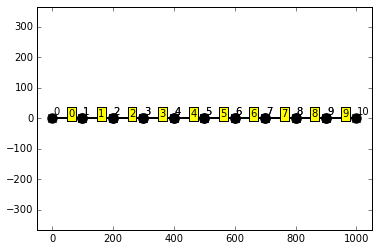

In [6]:
n_elements = 10
xnodes = np.linspace(0,1000,n_elements + 1)
ynodes = np.linspace(0,0,n_elements + 1)
nodes = np.array([xnodes,ynodes]).transpose()
n_nodes = xnodes.size
elements=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [7]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
f_x = 0*np.ones(ne)
f_y = 0*np.ones(ne)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, ndof-2])
bc_values = np.array([0, 0, 0])

In [8]:
K = frame.assemble_K()
F=frame.assemble_F()
#F[12]=F[12]-.5*EI[0]*np.pi**2
F[ndof-3]=F[ndof-3]-1.
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([ 0.        ,  0.        ,  0.        , -0.51282051,  0.        ,
        0.        , -1.02564103,  0.        ,  0.        , -1.53846154,
        0.        ,  0.        , -2.05128205,  0.        ,  0.        ,
       -2.56410256,  0.        ,  0.        , -3.07692308,  0.        ,
        0.        , -3.58974359,  0.        ,  0.        , -4.1025641 ,
        0.        ,  0.        , -4.61538462,  0.        ,  0.        ,
       -5.12820513,  0.        ,  0.        ])

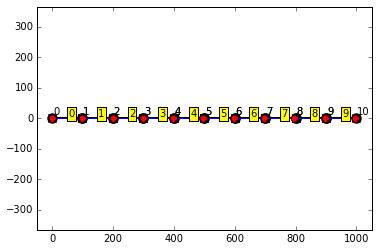

In [9]:
frame.set_displacement(Usol)
frame.plot_with_label()
frame.plot_displaced()

In [10]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof)

In [11]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 5, Gs, which = 'LA', sigma =4.)
print(val)

[  8.77865919e-03   4.50557314e+00   5.08998538e+00   5.43777076e+00
   3.74556940e+01]


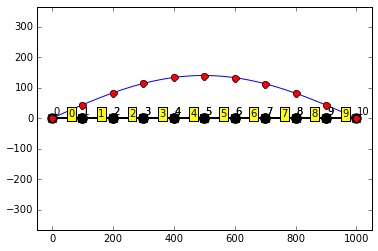

In [12]:
frame.set_displacement(10*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

In [13]:
E*I*np.pi**2/1000**2

## Essai sur exercice 2

In [14]:
E=1.3 #en MPa
h=7.5 #en mm
b=20. #en mm
Lx=55. #en mm
Lyh=60. #en mm
Lyb=45. #en mm
I=b*(h**3)/12 #en mm^4
S=b*h  #en mm^2
eps=10**(-3)
g=9.81 #en m.s^(-2)
m=0.05 #en kg

Frame with
7 elements
7 nodes
21 dofs


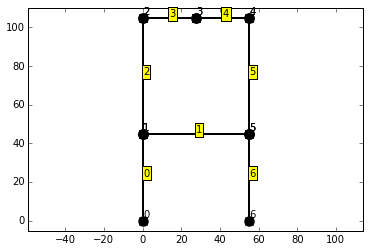

In [15]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [16]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
EI[1]=100*E*I;EI[3]=100*E*I;EI[4]=100*E*I
ES[1]=100*E*S;ES[3]=100*E*S;ES[4]=100*E*S
f_x = 0*np.ones(7)
f_y = 0*np.ones(7)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

In [17]:
K = frame.assemble_K()
F=frame.assemble_F()
#F[10]=F[10]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[10]=F[10]-1.
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -4.39259550e-06,  -1.15384615e-01,   1.78560218e-05,
         4.32514107e-06,  -2.69230769e-01,  -2.03130319e-03,
        -7.68273795e-16,  -3.06641245e-01,   1.23630733e-17,
        -4.32514108e-06,  -2.69230769e-01,   2.03130319e-03,
         4.39259550e-06,  -1.15384615e-01,  -1.78560218e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [18]:
frame.set_displacement(Usol)

In [19]:
Ge=frame.N_local_stress_tot()

In [20]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof)

In [21]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 3, Gs, which = 'LA', sigma = 3.)
print(val)
print(vect[:,0])


[   3.99767142    5.36565293  423.22822822]
[  5.15162734e-17  -2.21317756e-16   2.30236861e-17   6.50447440e-02
  -8.12498565e-01   1.63150037e-02  -4.17056613e+00  -8.60368598e-01
   1.80970747e-02  -4.17056550e+00  -3.74631231e-01   1.74435097e-02
  -4.17056488e+00   1.10807231e-01   1.80753363e-02   6.49168433e-02
   6.29371975e-02   1.61651694e-02   8.05378491e-17  -2.41237220e-17
   1.10936469e-16]


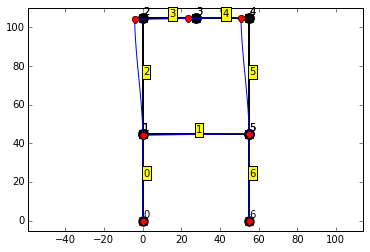

In [22]:
frame.set_displacement(1*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

# Essai sur d'autres structures

Structure avec des piliers au milieu :

Frame with
11 elements
8 nodes
24 dofs


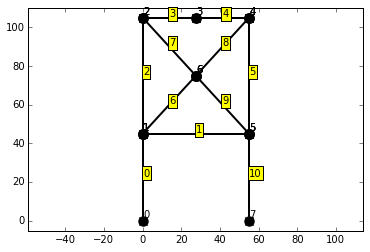

In [73]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx/2,Lyh/2+Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[1,6],[2,6],[4,6],[5,6],[5,7]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [74]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
EI[1]=100*E*I;EI[3]=100*E*I;EI[4]=100*E*I
ES[1]=100*E*S;ES[3]=100*E*S;ES[4]=100*E*S
f_x = 0*np.ones(ne)
f_y = 0*np.ones(ne)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

In [75]:
K = frame.assemble_K()
F=frame.assemble_F()
#F[10]=F[10]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[10]=F[10]-1.
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)

In [76]:
frame.set_displacement(Usol)

In [77]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof)

In [82]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 3, Gs, which = 'LA', sigma =4.)
print(val)
print(vect[:,1])

[ 4.29238722  4.81997583  5.59237037]
[ -2.10024045e-01   6.48754591e-02   9.51077802e-02  -2.11503428e-01
   2.17195147e-02   4.00677445e-01   3.45079161e+00  -8.53365029e-01
   1.20126920e+00   3.33484704e+00   4.64113976e+01   1.49331502e+00
   3.21890247e+00   4.17754594e+01  -9.79298171e-01  -1.08914486e+00
   4.00354974e+01  -2.99011769e-01   1.16861902e+00   1.37864384e+01
   2.15967691e-01  -1.27621393e-01  -1.16438534e-01  -7.36282926e-02]


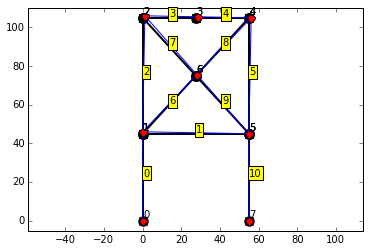

In [83]:
frame.set_displacement(1*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

Structure avec deux forces et sans étage renforcé :

Frame with
7 elements
7 nodes
21 dofs


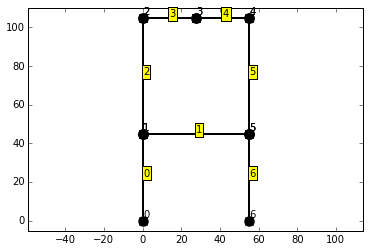

In [32]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

In [33]:
ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
f_x = 0*np.ones(7)
f_y = 0*np.ones(7)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

In [34]:
K = frame.assemble_K()
F=frame.assemble_F()
#F[7]=F[7]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
#F[13]=F[13]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[7]=F[7]-1.
F[13]=F[13]-1.
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -6.29467780e-17,  -2.30769231e-01,   1.02740472e-18,
        -1.74759662e-16,  -5.38461538e-01,  -1.71294976e-18,
        -1.84301087e-16,  -5.38461538e-01,  -4.59008729e-18,
        -1.94273943e-16,  -5.38461538e-01,   6.44367590e-18,
        -6.21930937e-17,  -2.30769231e-01,   7.71966980e-19,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [35]:
frame.set_displacement(Usol)

In [36]:
Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof)

In [37]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 6, Gs, which = 'LA', sigma =1.2)
print(val)
print(vect[:,0])

[  1.62612367   4.41193007   8.90251538  15.37359967  23.41273245
  97.27902096]
[  2.77555756e-17  -4.02546867e-46   5.55111512e-17  -1.99435709e-01
   8.51288281e-02  -2.62078016e-02   4.98621157e+00   1.30890161e-01
  -4.56213684e-02   4.98609326e+00   1.01036709e-02   1.63290397e-02
   4.98597495e+00  -9.89447761e-02  -4.47676925e-02  -1.78164779e-01
  -5.31834429e-02  -2.39053031e-02   5.55111512e-17   1.32191961e-46
  -1.62897498e-46]


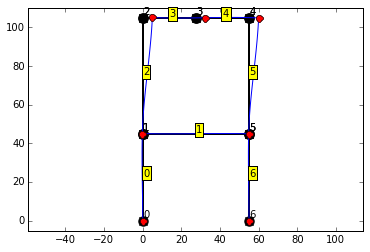

In [38]:
frame.set_displacement(1*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()

Structure croisée :

Frame with
9 elements
7 nodes
21 dofs


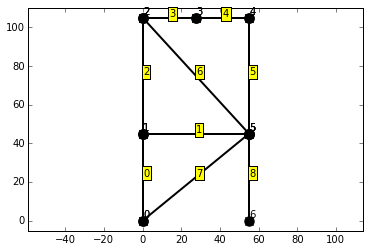

In [42]:
nodes= np.array([[0.,0.],[0.,Lyb],[0.,Lyh+Lyb],[Lx/2,Lyh+Lyb],[Lx,Lyh+Lyb],[Lx,Lyb],[Lx,0.]])
elements=np.array([[0,1],[1,5],[1,2],[2,3],[3,4],[4,5],[2,5],[0,5],[5,6]])

frame= Frame_Buckling(nodes,elements)
frame.plot_with_label()

ne = frame.nelements
ndof = frame.ndof
EI = np.ones(ne)*E*I
ES = np.ones(ne)*E*S
f_x = 0*np.ones(ne)
f_y = 0*np.ones(ne)
frame.set_distributed_loads(f_x, f_y)
frame.set_stiffness(EI, ES)
blocked_dof = np.array([0, 1, 2, ndof-3, ndof-2, ndof-1])
bc_values = np.array([0, 0, 0, 0, 0, 0])

K = frame.assemble_K()
F=frame.assemble_F()
#F[7]=F[7]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
#F[13]=F[13]-.5*EI[0]*np.pi**2/(Lyb+Lyh)**2
F[10]=F[10]-1.
Kbc, Fbc = frame.bc_apply(K, F, blocked_dof, bc_values)
Usol = np.linalg.solve(Kbc,Fbc)
Usol

frame.set_displacement(Usol)

Gbc=frame.assemble_G()
G=frame.bc_apply_G(Gbc,blocked_dof)

[ 21.18128728  33.6874556   36.74038562]


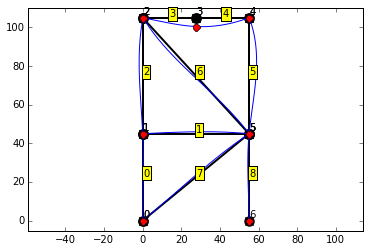

In [61]:
Ks = sparse.csr_matrix(K)
Gs = sparse.csr_matrix(G)
val, vect = linalg.eigsh(Ks, 3, Gs, which = 'LA', sigma =9.)
print(val)
frame.set_displacement(1*vect[:,0])
frame.plot_with_label()
frame.plot_displaced()